pacotes necessários

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 12

bases de dados

In [2]:
petr = pd.read_excel('petr4.xlsx')
brent = pd.read_excel('brent.xlsx')

In [3]:
petr.columns = ['data','PETR4 (R$)']
brent.columns = ['data','Brent (US$)']

In [4]:
petr.set_index('data', inplace=True)
brent.set_index('data', inplace=True)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

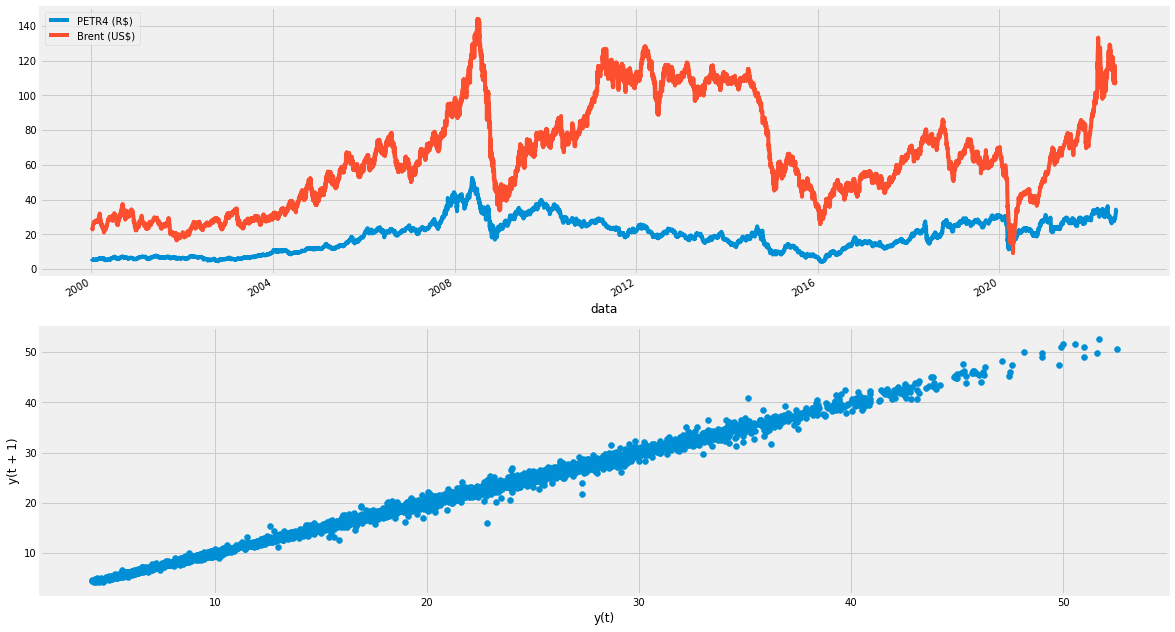

In [5]:
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
petr.plot(ax=ax1, label='PETR4 (R$)') #series plot
brent.plot(ax=ax1, label='Brent (US$)')
pd.plotting.lag_plot(petr) #lag plot

teste de estacionaridade

In [7]:
from statsmodels.tsa.stattools import adfuller   


In [8]:
#Determing rolling statistics
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(252).mean()
    rolling_std = timeseries.rolling(252).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Média Móvel')
    std = plt.plot(rolling_std, color='black', label = 'Variância Móvel')
    plt.legend(loc='best')
    plt.title('Média Móvel & Variância Móvel')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

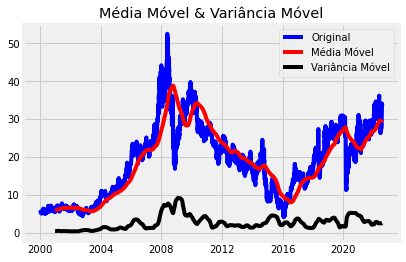

Results of Dickey-Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


In [9]:
test_stationarity(petr)

Fazendo da série uma estacionária (Diferenciação)

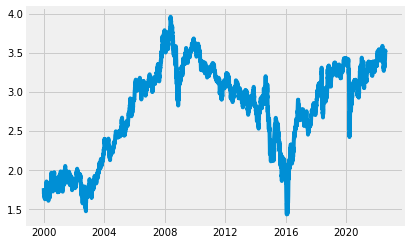

In [10]:
ts_log = np.log(petr)
plt.plot(ts_log)

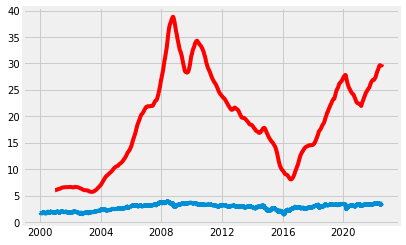

In [11]:
moving_avg = petr.rolling(252).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,PETR4 (R$)
data,
2000-01-03,NaN
2000-01-04,NaN
2000-01-05,NaN
2000-01-06,NaN
2000-01-07,NaN
2000-01-10,NaN
2000-01-11,NaN
2000-01-12,NaN
2000-01-13,NaN


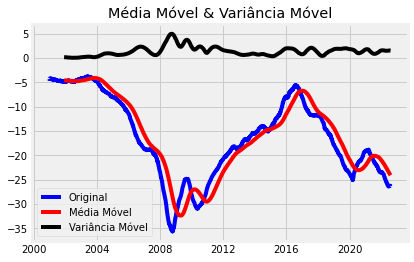

Results of Dickey-Fuller Test:
Test Statistic                   -2.087860
p-value                           0.249424
#Lags Used                       28.000000
Number of Observations Used    5397.000000
Critical Value (1%)              -3.431562
Critical Value (5%)              -2.862076
Critical Value (10%)             -2.567055
dtype: float64


In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

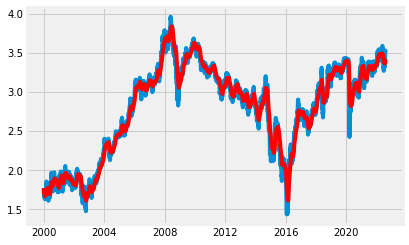

In [14]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

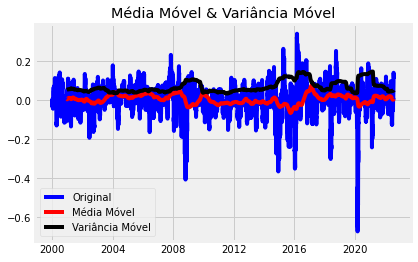

Results of Dickey-Fuller Test:
Test Statistic                -1.188616e+01
p-value                        6.016712e-22
#Lags Used                     7.000000e+00
Number of Observations Used    5.669000e+03
Critical Value (1%)           -3.431504e+00
Critical Value (5%)           -2.862050e+00
Critical Value (10%)          -2.567041e+00
dtype: float64


In [15]:
ts_log_ewma_diff = ts_log - expwighted_avg 
test_stationarity(ts_log_ewma_diff)

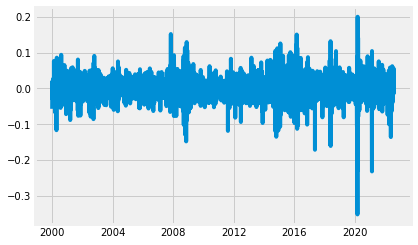

In [16]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

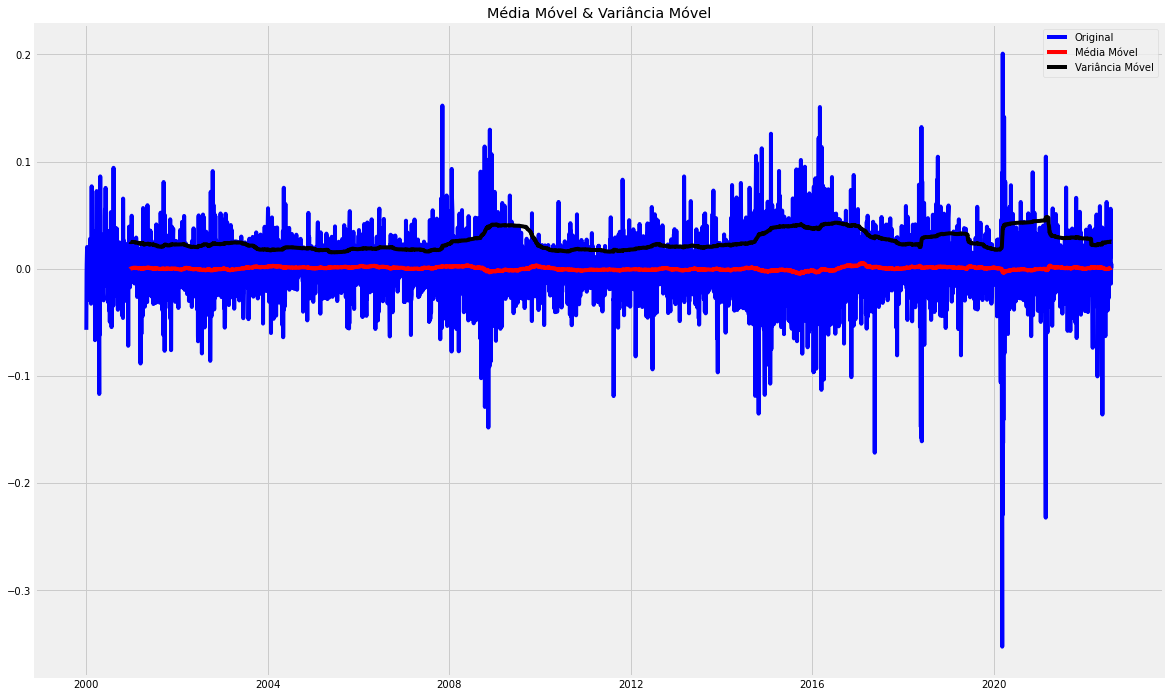

Results of Dickey-Fuller Test:
Test Statistic                  -27.488936
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    5669.000000
Critical Value (1%)              -3.431504
Critical Value (5%)              -2.862050
Critical Value (10%)             -2.567041
dtype: float64


In [32]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Previsão

In [18]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

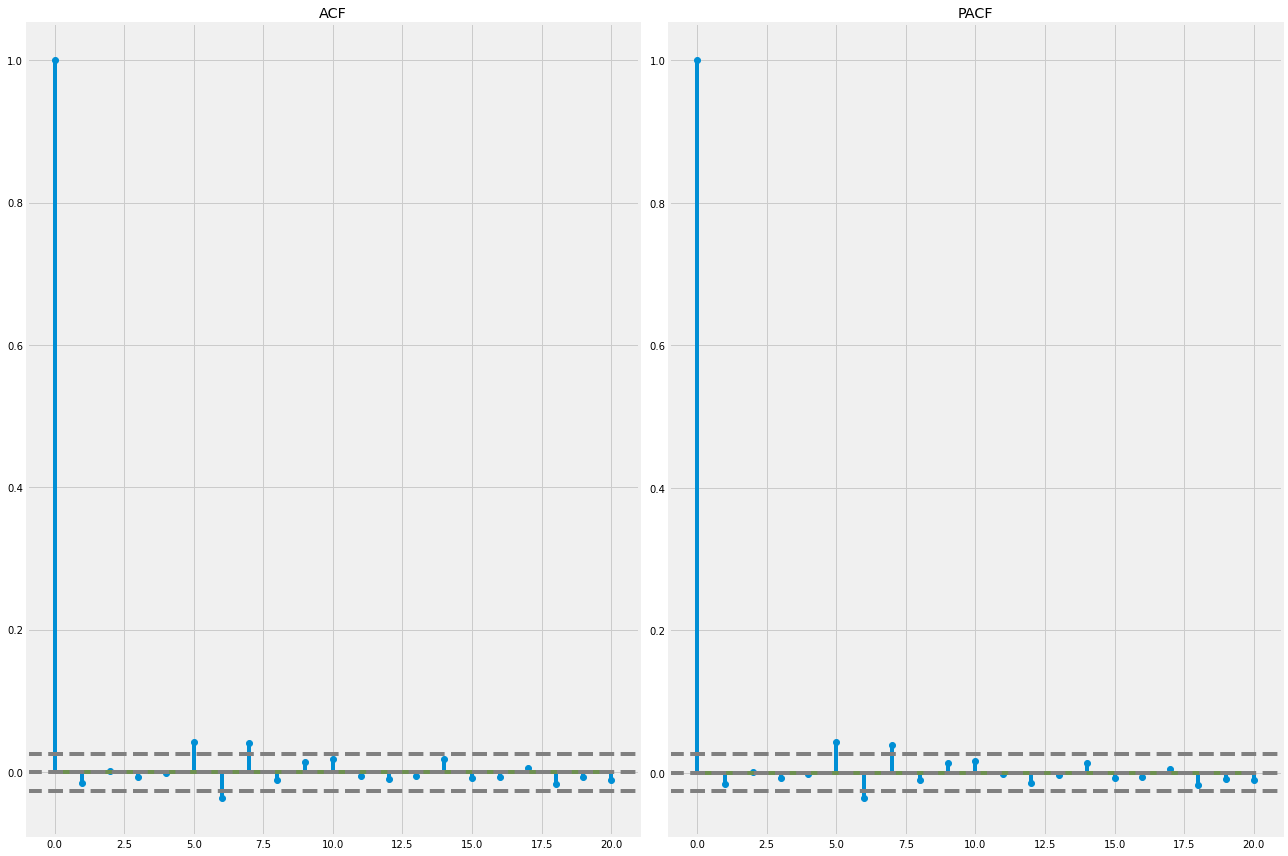

In [119]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('ACF')

#Plot PACF: 
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray') 
plt.title('PACF') 
plt.tight_layout()

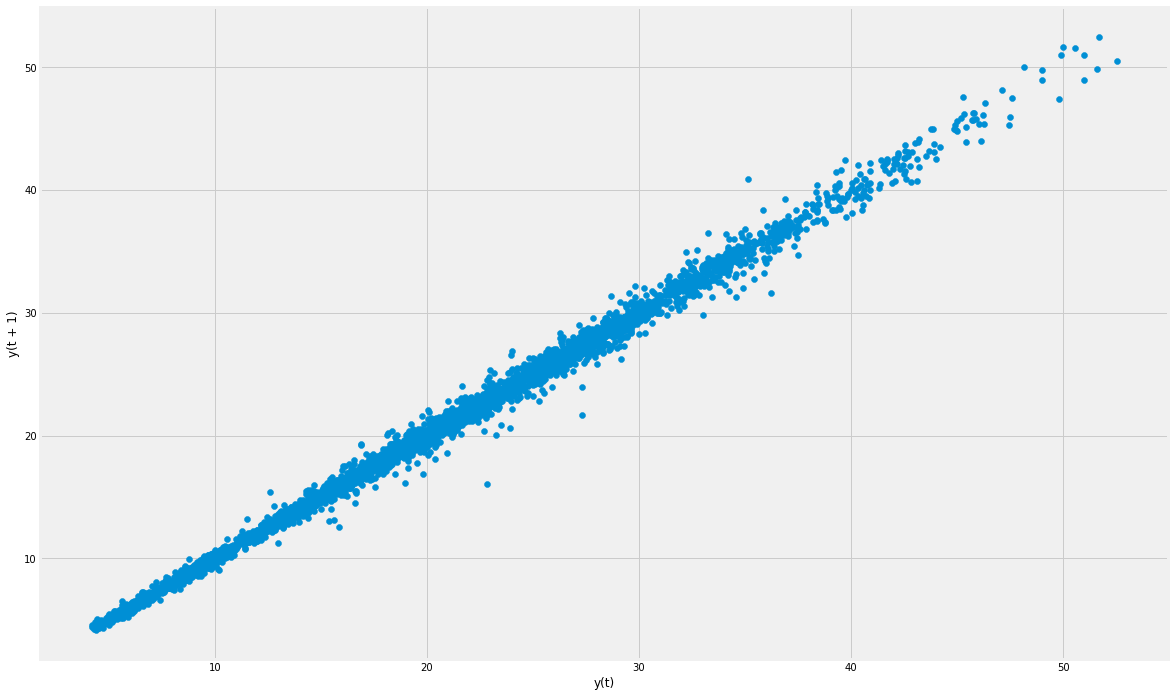

In [81]:
from matplotlib import pyplot
from pandas.plotting import lag_plot

lag_plot(petr)
pyplot.show()

In [87]:
values = pd.DataFrame(petr.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.998386
t+1  0.998386  1.000000


In [91]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

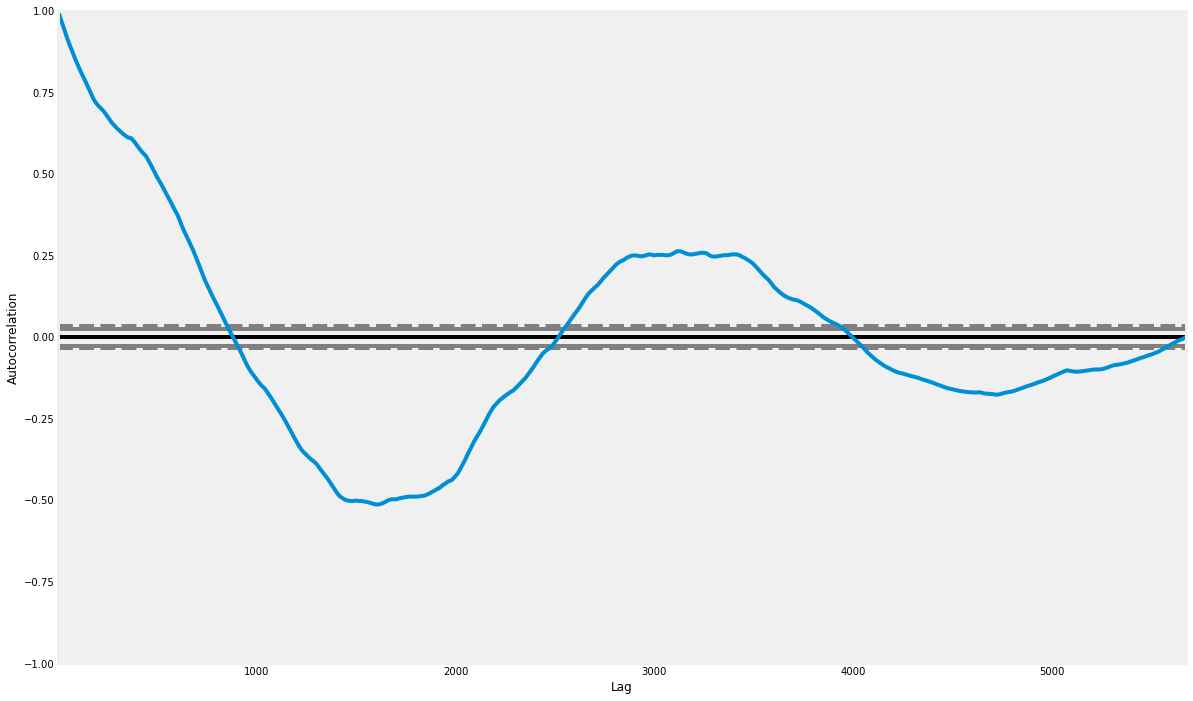

In [93]:
autocorrelation_plot(petr)

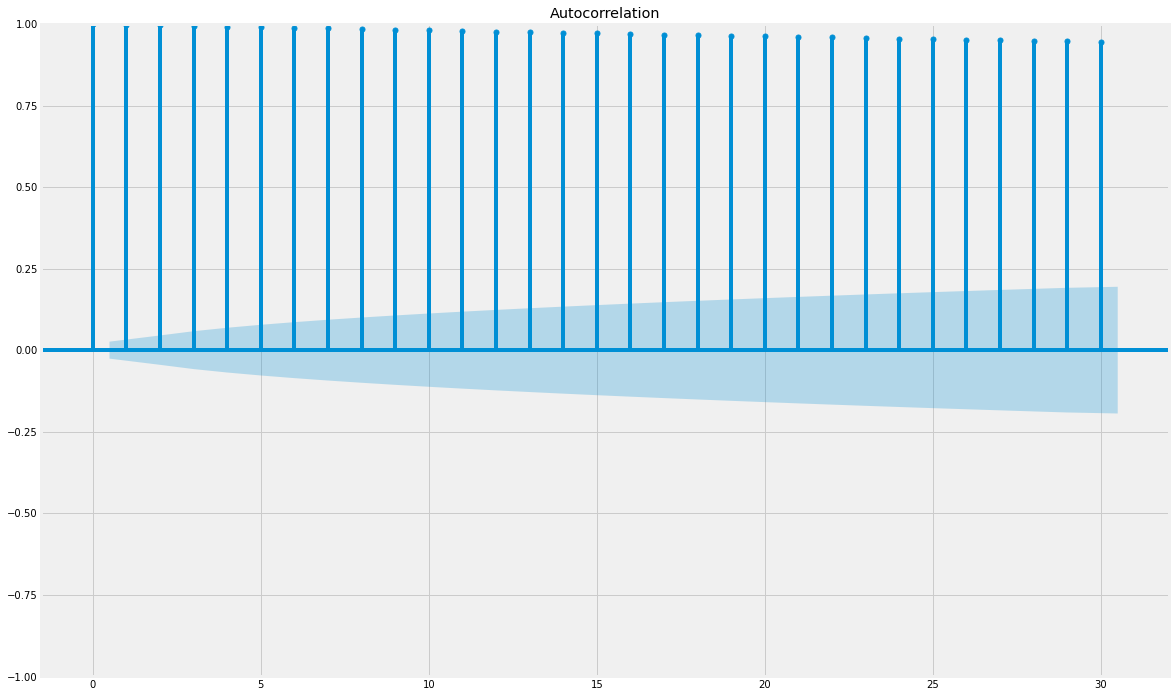

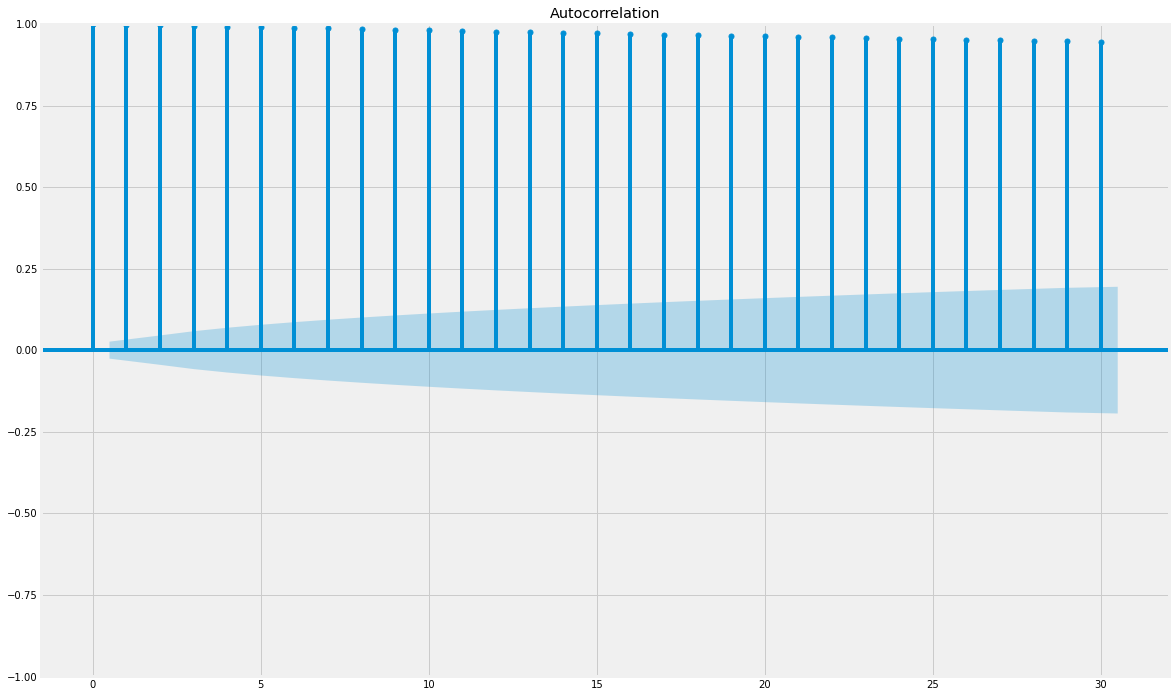

In [98]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(petr, lags=30)

In [99]:
petr

,PETR4 (R$)
data,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-29,34.150002
2022-08-01,33.680000
2022-08-02,33.830002


In [101]:
from statsmodels.tsa.ar_model import AutoReg

In [105]:

#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(petr, lags=252).fit()
#
# Print Summary
#
print(ar_model.summary())

c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:             PETR4 (R$)   No. Observations:                 5677
Model:                   AutoReg(252)   Log Likelihood               -4268.047
Method:               Conditional MLE   S.D. of innovations              0.531
Date:                Thu, 04 Aug 2022   AIC                           9044.093
Time:                        16:54:02   BIC                          10720.182
Sample:                           252   HQIC                          9629.116
                                 5677                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0314      0.017      1.811      0.070      -0.003       0.065
PETR4 (R$).L1       0.9995      0.014     73.620      0.000       0.973       1.026
PETR4 (R$).L2      -0.0145      

c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\est.matheus.brasil\Anaconda3\envs\econometria\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


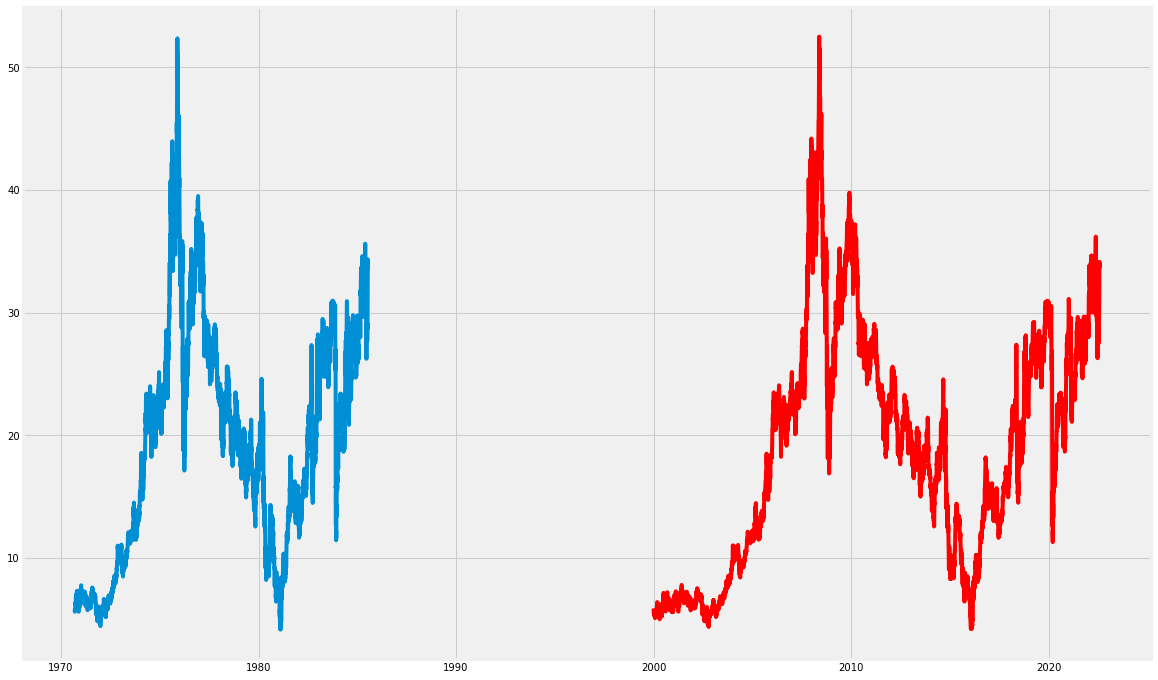

In [117]:
#
# Make the predictions
#
pred = ar_model.predict(start=0, end=len(petr), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(petr, color='red')